In [1]:
# Global inversion with empymod

#%matplotlib notebook

# Code for Global Inversion 

In [2]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed

Creating a synthetic model

In [3]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
dip = np.array([0, 90])

Hreceivers = [offsets, offsets*0, 0, 0, 0]
Vreceivers = [offsets, offsets*0, 0, 0, 90]

# Source geometry

Hsource = [0, 0, 0 ,0 , 0]
Vsource = [0, 0, 0, 0, 90]

# Frequency

freq = 9000

In [4]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50

In [5]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

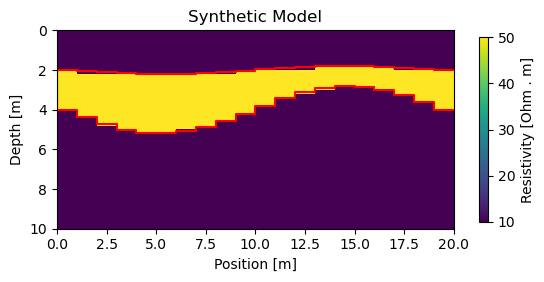

In [6]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

Define forward model function

In [7]:
def EMforward(x):
    # x is input model
    surface = np.array([0])
    thkx = np.array(x[0:2])
    depthx = np.hstack((surface, thkx[0], thkx[0]+thkx[1]))
    res_ground = np.array(x[2:])
    res_air = np.array([2e14])
    resx = np.hstack((res_air, res_ground))
    HCP = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP = empymod.loop(Hsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
    Z = np.hstack((HCP, VCP, PRP))
    return Z

Load solutions hypercube

In [8]:
Zcube = np.load('Zcube11.npy')

In [9]:
np.shape(Zcube)

# 5 resistivities 1st layer
# 5 resistivities 2nd layer
# 5 resistivities 3rd layer
# 5 thicknesses 1st layer
# 5 thicknesses 2nd layer

(11, 11, 11, 11, 11, 9)

In [10]:
Zcube[0,0,0,0,0,:]

array([-1.00933471e-08-9.52898553e-09j, -1.00739701e-08-9.12292107e-09j,
       -9.98642664e-09-8.28139446e-09j,  4.82113418e-07-1.94956467e-08j,
        2.31001580e-07-1.90021729e-08j,  1.05402343e-07-1.74273211e-08j,
        5.02021823e-07-1.36501868e-09j,  2.50592772e-07-2.23558410e-09j,
        1.24470153e-07-3.48448146e-09j])

In [11]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data.append(EMforward(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [12]:
nsl = 11 # sampling number of the cube

s0 = -2 # minimum conductivity in S/m
s1 = -0.8 # maximum conductivity in S/m
# conductivities array
conds = np.logspace(s0, s1, nsl)

th0 = 0.1 # minimum thickness in m
th1 = 5   # maximum thickness in m
# thickness array
thicks = np.linspace(th0, th1, nsl)

Create grid search

In [13]:
def gridsearch(Zdata):
    err = 1
    
    for is1 in range(nsl):
        for is2 in range(nsl):
            for is3 in range(nsl):
                for it1 in range(nsl):
                    for it2 in range(nsl):
                        Z = Zcube[is1, is2, is3, it1, it2, :]
                        nZdiff = np.abs(Z - Zdata) **2 / np.abs(Zdata)**2

                        merr = np.log10(np.sqrt(np.sum(nZdiff)))

                        if merr < err: # until error increases
                            # set model values
                            ms1 = is1
                            ms2 = is2
                            ms3 = is3
                            mt1 = it1
                            mt2 = it2
                            err = merr
                            
    model = [thicks[mt1], thicks[mt2], 1/conds[ms1], 1/conds[ms2], 1/conds[ms3]]
    return model

In [14]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = gridsearch(dataE)
    
    model_est_list.append(model_est)
    
    print('Estimated position ', i)

# Model estimation array    
model_est_arr = np.array(model_est_list)

Estimated position  0
Estimated position  1
Estimated position  2
Estimated position  3
Estimated position  4
Estimated position  5
Estimated position  6
Estimated position  7
Estimated position  8
Estimated position  9
Estimated position  10
Estimated position  11
Estimated position  12
Estimated position  13
Estimated position  14
Estimated position  15
Estimated position  16
Estimated position  17
Estimated position  18
Estimated position  19


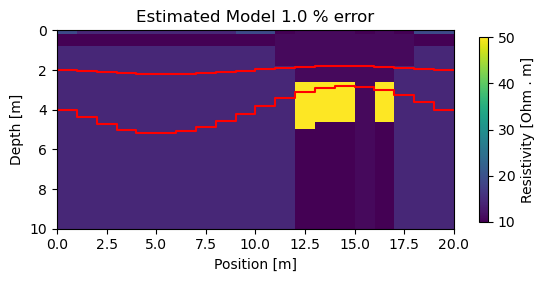

In [15]:
# Plot estimated model

depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')